## <span style='color:#ff5f27'> 📝 Imports</span>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import partial

from functions.utils import show_image
from functions.t5 import encode_text
from functions.vqgan import (
    load_vqgan_model, 
    load_process_encode_rgb_image, 
    generate_iteration, 
)
from functions.transistor_training import (
    FilteredTextImageDataset,
    collate_fn,
)
from functions.transistor import (
    generate_image_from_text,

)
import config

In [2]:
import wandb
wandb.login(key='287bb16bd939a26bd58a1fb72c38038e952d8e70')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/yarnapp/.netrc


True

## <span style='color:#ff5f27'> 🤖 Model Loading</span>

In [3]:
# Load SFLCKR VQGAN
vqgan_model = load_vqgan_model(
    config.VQGAN_CONFIG_SFLCKR,
    config.VQGAN_CHECKPOINT_SFLCKR,
).to(config.DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
2024-09-15 21:28:46,895 INFO: number of parameters: 3.049329e+08
Restored from logs/2020-11-09T13-31-51_sflckr/model_ckpt/last.ckpt
✅ Done!


## <span style='color:#ff5f27'> ⚙️ Text Encoding</span>

In [4]:
input_text = [
    config.PROMPT,
]

In [5]:
config.PROMPT

'A beautiful sunset over a city skyline.'

In [6]:
text_token_embeds, text_mask = encode_text(
    'A beautiful sunset over a city skyline.', 
    name='t5-large', 
    output_device=config.DEVICE,
)
text_token_embeds.shape

/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

torch.Size([39, 3, 1024])

## <span style='color:#ff5f27'> 🗄️ Data Loader</span>

In [7]:
# Improved data augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

filtered_dataset = FilteredTextImageDataset(
    json_file='mc_coco/annotations/captions_val2017.json', 
    img_dir='mc_coco/val2017', 
    transform=transform,
    min_dim=256
)

🔎 Filtered 4564 images out of 25014


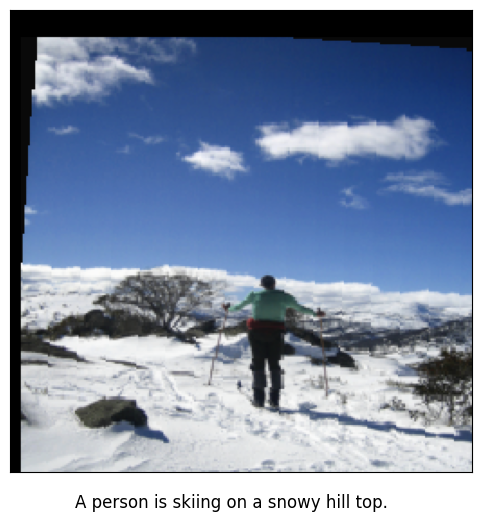

In [8]:
filtered_dataset.visualize_sample(120)

In [9]:
# Split the validation dataset into training and validation subsets
train_size = int(0.8 * len(filtered_dataset))  # Use 80% for training
val_size = len(filtered_dataset) - train_size  # Use 20% for validation
train_dataset, val_dataset = random_split(filtered_dataset, [train_size, val_size])

print(f"Total dataset size: {len(filtered_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)

Total dataset size: 4564
Training set size: 3651
Validation set size: 913




## <span style='color:#ff5f27'> 🧬 Transistor Architecture</span>

In [10]:
class Transistor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=6, dropout_rate=0.1):
        super(Transistor, self).__init__()
        self.layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.layer_norms.append(nn.LayerNorm(hidden_dim))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layer_norms.append(nn.LayerNorm(hidden_dim))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.GELU()
    
    def forward(self, x):
        for i, (layer, layer_norm) in enumerate(zip(self.layers[:-1], self.layer_norms)):
            x_res = x
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)
            x = layer_norm(x)
            if i > 0:  # Skip connection for all but the first layer
                x = x + x_res
        return self.layers[-1](x)

In [11]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

## <span style='color:#ff5f27'> 🏃🏻‍♂️ Transistor Training</span>

In [12]:
@torch.no_grad()
def preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device):
    text_latents, _ = encode_text_fn(captions)
    text_latents = text_latents.mean(dim=1)  # Average over token dimension
    
    image_latents = []
    for img_path in img_paths:
        z, _ = load_process_encode_rgb_image(img_path, vqgan_model, device=device)
        image_latents.append(z.view(1, -1))  # Flatten to [1, 256*16*16]
    image_latents = torch.cat(image_latents, dim=0)
    return text_latents.to(device), image_latents.to(device)

@torch.no_grad()
def validate(transistor_model, val_loader, vqgan_model, criterion, device, encode_text_fn):
    transistor_model.eval()
    total_loss = 0
    for captions, _, img_paths in val_loader:
        text_latents, image_latents = preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device)
        outputs = transistor_model(text_latents)
        loss = criterion(outputs, image_latents)
        total_loss += loss.item()
    return total_loss / len(val_loader)

In [18]:
def train_model(transistor_model, train_loader, val_loader, vqgan_model, criterion, optimizer, device, num_epochs=100, accumulation_steps=4):
    wandb.init(project="text-to-image-transistor-sflckr", config={
        "model_architecture": "ImprovedTransistor",
        "num_layers": len(transistor_model.layers),
        "hidden_dim": transistor_model.layers[0].out_features,
        "dropout_rate": transistor_model.dropout.p,
        "activation": "GELU",
        "learning_rate": optimizer.param_groups[0]['lr'],
        "scheduler": "CosineAnnealingWarmRestarts",
        "epochs": num_epochs,
        "batch_size": train_loader.batch_size,
        "accumulation_steps": accumulation_steps,
    })
    
    transistor_model.train()
    scaler = torch.cuda.amp.GradScaler()
    encode_text_fn = partial(encode_text, name='t5-large', output_device=device)
    early_stopping = EarlyStopping(patience=20, min_delta=0.0001)
    
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for i, (captions, _, img_paths) in enumerate(pbar):
            text_latents, image_latents = preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device)
            
            with torch.cuda.amp.autocast():
                outputs = transistor_model(text_latents)
                loss = criterion(outputs, image_latents)
            
            loss = loss / accumulation_steps
            scaler.scale(loss).backward()
            
            if (i + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(transistor_model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
                
            running_loss += loss.item() * accumulation_steps
            pbar.set_postfix({'loss': running_loss / (i + 1)})
        
        scheduler.step()
        
        avg_train_loss = running_loss / len(train_loader)
        val_loss = validate(transistor_model, val_loader, vqgan_model, criterion, device, encode_text_fn)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
            
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "learning_rate": optimizer.param_groups[0]['lr']
        })
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(transistor_model.state_dict(), 'best_transistor_model.pth')
            print(f"💾 Saved best model with validation loss: {best_val_loss:.4f}")
            
        if (epoch + 1) % 5 == 0:
            text = 'Beautiful green forest with a lot of green trees'
            generated_image = generate_image_from_text(text, transistor_model, vqgan_model, encode_text_fn, device)
            wandb.log({"generated_image": wandb.Image(generated_image)})
            
    wandb.finish()
    print("✅ Training completed.")

In [19]:
# Initialize Transistor model
input_dim = 1024  # Dimension of T5 output
hidden_dim = 3072  # Increased from 2048
output_dim = 256 * 16 * 16
transistor_model = Transistor(input_dim, hidden_dim, output_dim, num_layers=6, dropout_rate=0.1).to(config.DEVICE)

In [20]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(transistor_model.parameters(), lr=0.0001, weight_decay=0.01)

🕰️ Time: 12.12 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


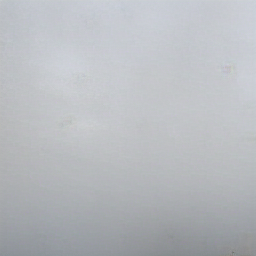

✅ All iterations completed.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,█▇▃▂██▇▆▄▃▂▁███▇▇▆▆▅▄▃▃▂▂▁▁▁█████▇▇▇▇▇▆▆
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
learning_rate,7e-05
train_loss,0.47781
val_loss,0.48864


Training completed.


In [21]:
# Train the model
train_model(
    transistor_model, 
    train_loader, 
    val_loader, 
    vqgan_model,
    criterion,
    optimizer,
    config.DEVICE, 
    num_epochs=100,
    accumulation_steps=4,
)

---